In [1]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver, NumPyMinimumEigensolver
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries, MatrixOp
from qiskit import IBMQ, BasicAer, Aer
#from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.library import RealAmplitudes
from qiskit.aqua.operators.legacy import WeightedPauliOperator
from qiskit.aqua.operators import (TPBGroupedWeightedPauliOperator,
                                    WeightedPauliOperator,
                                    MatrixOperator)
import warnings
import time

What follows is the finite difference solution to the Schrodinger equation. The current potential is set to the harmonic oscillator potential, but it can be changed to any other potential in the definition of the function Vpot(). Sometimes when you run this next cell, especially for the first time after opening this notebook, it may give an error saying eigenvalue did not converge. Run it again and it should work.

enter lower limit of the domain: -6
enter upper limit of the domain: 6
Finite Difference Energies:  [0.49893263 1.49465392 2.48607321 3.47316207]
Theoretical Energies:  [0.5 1.5 2.5 3.5]
Percent Error:  [0.21393113 0.3576804  0.56019236 0.77272324]


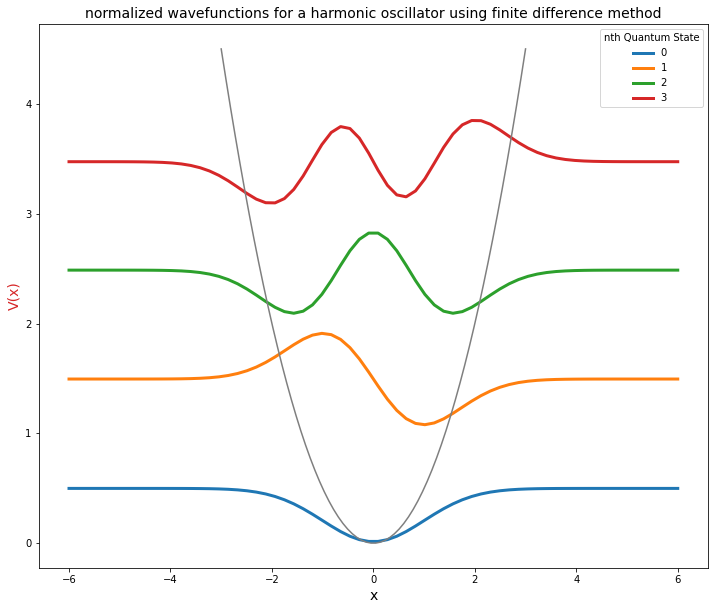

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import math

# Define potential energy function. Change this to change the potential.
def Vpot(x):
    return (1/2)*x**2

# Enter computational parameters
a = float(input('enter lower limit of the domain: '))
b = float(input('enter upper limit of the domain: '))

# Here's where the number of qubits are set. The Hamiltonian will be have a size of (N-2)x(N-2)
qubits = 6
N = (2**qubits)+2


# Define x grid and step size
x = np.linspace(a,b,N)
h = x[1]-x[0]

# Create Kinetic Energy Matrix
T = np.zeros((N-2)**2).reshape(N-2,N-2)
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            T[i,j]= -2
        elif np.abs(i-j)==1:
            T[i,j]=1
        else:
            T[i,j]=0

# Create Potential Energy Matrix
V = np.zeros((N-2)**2).reshape(N-2,N-2)
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            V[i,j]= Vpot(x[i+1])
        else:
            V[i,j]=0
            
# Create Hamiltonian
H = -T/(2*h**2) + V

# Find eigenvalues and eigenvectors, then sort them in ascending order
val,vec=np.linalg.eig(H)
z = np.argsort(val)
z = z[0:4]
energies=(val[z])
print("Finite Difference Energies: ", energies)

# Compare finite difference calculation to theoretical calculation
nVec=np.linspace(0,len(energies)-1,len(energies))
En = (nVec + 0.5)
print("Theoretical Energies: ", En)
percentError = ((En-energies)/(energies))*100
print("Percent Error: ", percentError)

# Plot wavefunctions for first 4 lowest states
plt.figure(figsize=(12,10))
scalingFactor=1.5
for i in range(len(z)):
    y = []
    y = np.append(y,vec[:,z[i]])
    y = np.append(y,0)
    y = np.insert(y,0,0)
    plt.plot(x,scalingFactor*y+energies[i],lw=3, label="{} ".format(i))
plt.xlabel('x', size=14)
plt.ylabel('V(x)',size=14,color='tab:red')
plt.legend(title="nth Quantum State")
plt.title('normalized wavefunctions for a harmonic oscillator using finite difference method',size=14)

# Create x and potential vectors for plotting

# The next line returns the square root of the last element of the energies array. It will be used when plotting the domain
# of the harmonic potential.
highestEnergy = math.sqrt(2*energies[len(energies)-1]) 
xplot = np.linspace(-math.ceil(highestEnergy),math.ceil(highestEnergy),N)
Vplot = Vpot(xplot)
plt.plot(xplot,Vplot,color='tab:gray')

plt.show()

Now, we take the Hamiltonian matrix and map it onto a qubit operator. There may be better ways to do this now that Qiskit has added new ways to map Hamiltonians to qubit operators.

In [4]:
start_time = time.time()
warnings.filterwarnings("ignore")

hamMatrixOp = MatrixOp(primitive=H)
HamPauliOP = hamMatrixOp.to_pauli_op()
qubitOp = HamPauliOP.to_legacy_op()

print("Size of Hamiltonian:", np.shape(H))
print(qubitOp)
# The next line shows the pauli string. You can comment it so that the output isn't so messy.
print(qubitOp.print_details())
#print(type(qubitOp))
end_time = time.time()

runtime = end_time-start_time
print('Program runtime: ',runtime)

Size of Hamiltonian: (64, 64)
Representation: paulis, qubits: 6, size: 79
IIIIII	(35.15566239316232+0j)
IIIIIX	(-14.670138888888856+0j)
IIIIXX	(-7.335069444444428+0j)
IIIIYY	(-7.335069444444428+0j)
IIIIZZ	(0.017041420118340866+0j)
IIIXXX	(-3.6675347222222134+0j)
IIIXYY	(3.6675347222222134+0j)
IIIYXY	(-3.6675347222222134+0j)
IIIYYX	(-3.6675347222222134+0j)
IIIZIZ	(0.034082840236686285+0j)
IIIZZI	(0.0681656804733729+0j)
IIXXXX	(-1.8337673611111063+0j)
IIXXYY	(1.8337673611111063+0j)
IIXYXY	(1.8337673611111063+0j)
IIXYYX	(1.8337673611111063+0j)
IIYXXY	(-1.8337673611111063+0j)
IIYXYX	(-1.8337673611111063+0j)
IIYYXX	(-1.8337673611111063+0j)
IIYYYY	(1.8337673611111063+0j)
IIZIIZ	(0.06816568047337201+0j)
IIZIZI	(0.13633136094674547+0j)
IIZZII	(0.2726627218934917+0j)
IXXXXX	(-0.9168836805555531+0j)
IXXXYY	(0.9168836805555531+0j)
IXXYXY	(0.9168836805555531+0j)
IXXYYX	(0.9168836805555531+0j)
IXYXXY	(0.9168836805555531+0j)
IXYXYX	(0.9168836805555531+0j)
IXYYXX	(0.9168836805555531+0j)
IXYYYY	(-0.91

Next, we create the variational form.

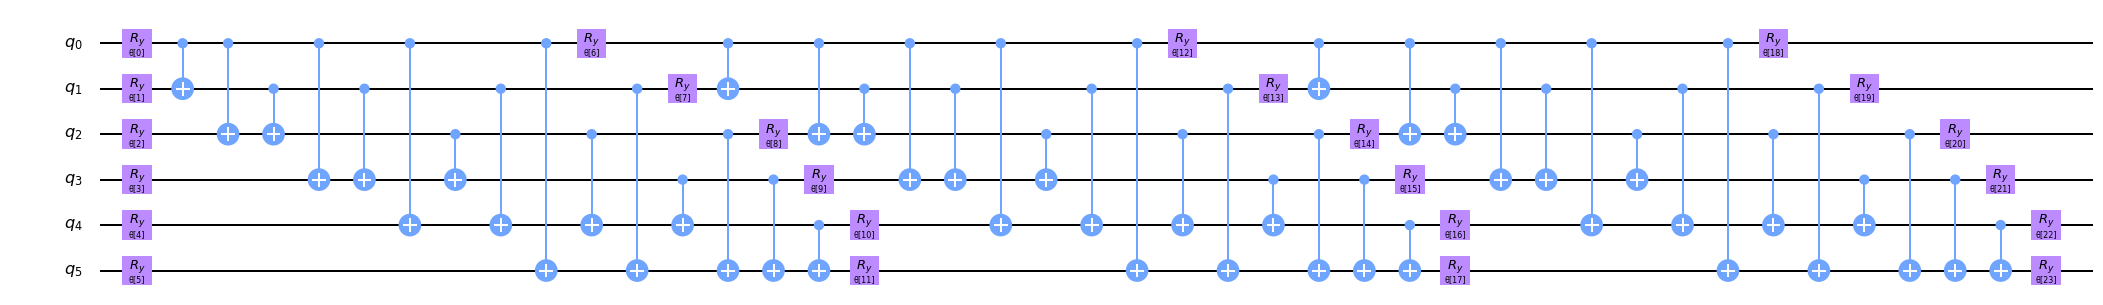

In [5]:
var_form = EfficientSU2(qubitOp.num_qubits, su2_gates=['ry'], entanglement="full", reps=3)
display(var_form.draw(output='mpl',fold=100))

In the next cell, we check the exact minimum eigenvalue of the qubit operator to make sure that our Hamiltonian mapped correctly.

In [6]:
exact_solution = NumPyEigensolver(qubitOp).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

Exact Result: [0.49893263]


Now, we can run the VQE algorithm. Make sure to make the appropriate changes to the code if running different simulators. The curent simulator is the statevector simulator.

In [7]:
start_time = time.time()
warnings.filterwarnings("ignore")

#Uncomment the next two lines if running the statevector simulator. In that case, comment the lines for the Qasm simulator.
backend = BasicAer.get_backend("statevector_simulator")
optimizer = SLSQP(maxiter=600)

# Uncomment the next 3 lines if running the Qasm simulator. In that case, comment the previous two lines. 
#backendQasm = BasicAer.get_backend('qasm_simulator')
#quantum_instance = QuantumInstance(backend=backendQasm, shots=8000)
#optimizerQasm = SPSA(max_trials=600)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# In the arguements for VQE() and vqe.run(), make sure to set the proper optimizer and backend for the intended simulator.
# If running the Qasm simulator, change vqe.run(backend) to vqe.run(quantum_instance).
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
ret = vqe.run(backend)
vqe_result = np.real(ret['eigenvalue'])
print("VQE Result:", vqe_result)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime:',runtime, "s")

VQE Result: 0.64715154884494
Program runtime: 11.48918080329895 s


Finally, we plot a convergence plot of the VQE results.

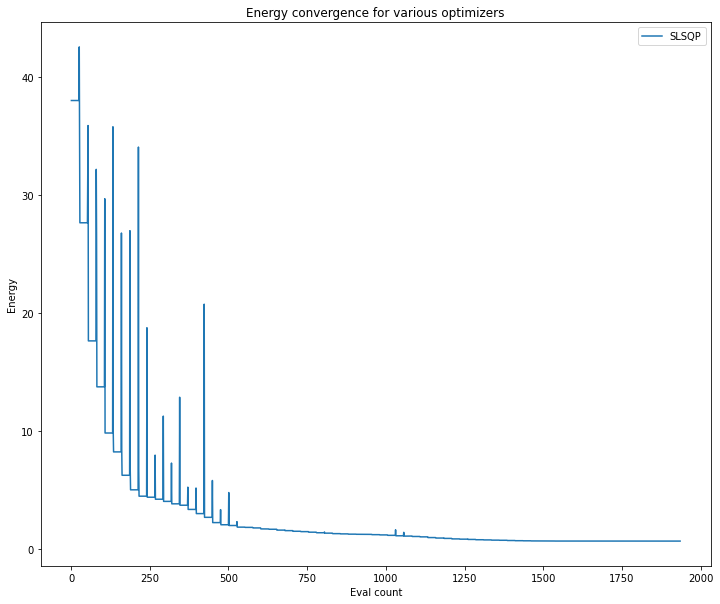

In [8]:
# Plot convergence plot
plt.figure(figsize=(12,10))
plt.plot(counts, values, label="SLSQP")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence for various optimizers')
plt.legend(loc='upper right')